# **Week 9: Word2Vec**

![picture](https://drive.google.com/uc?id=1Ren0qgAnsDGkgN_cnfCcE66GZAZfhMAp)



## **1.  We will implement Word2Vec. (Skip-gram)**
1-1. Define Tokenizer : For training Word2Vec, Must tokenize sentences. <br> 
1-2. Build Vocabulary : For preventing overfitting, Set min frequency of word <br>
1-3. Define Skipgram <br>
1-4. Implement Word2Vec with proper loss function.

## **2.  We will implement SentencePiece and Word2Vec.**
2-1. SentencePiece <br>
2-2. Word2Vec and Visualization

## **3.  HOMEWORK**
3-1. MosesTokenizer && BPE (Mainly used in translation) <br><br>

If you have any questions, feel free to ask

*   E-Mail Address : seongjunyang@kaist.ac.kr


## **1. Implement Word2Vec**


### **1) Import required packages**

In [ ]:
from abc import ABC
from typing import List, Dict, Tuple, Set
import random
import torch.nn.functional as F
from typing import List, Dict, Tuple
from random import randint
import re
from collections import Counter
import torch
from torch.utils.data import IterableDataset

### **2) Make Tokenizing**

In [ ]:
#Implement simple sentence tokenizer
#Punctuation marks should be a seperate token: . , ! ?
#For this tokenizing function, 're' library might be helpful but it is not mandatory.

def tokenize(sentence):

    ###################################################
    # TODO: Separate tokens by . , ! ?
    sentence = re.sub("[.]", " . ", sentence)
    sentence = re.sub("[,]", " , ", sentence)
    sentence = re.sub("[!]", " ! ", sentence)
    sentence = re.sub("[?]", " ? ", sentence)
    tokens = sentence.split()
    ###################################################
    assert type(tokens) == list # tokens must be a list of words. 
    return tokens

#Example: 'Don\'t be fooled, but be clever.'
#==> ['Don\'t', 'be', 'fooled', ',', 'but', 'be', 'clever', '.']

### **3) Tokenizing Test**

In [ ]:
def test_tokenize(sentence, hypothesis):
  tokens = tokenize(sentence)
  print("## Your tokenized result : ", tokens)
  assert tokens == hypothesis, \
    "Your tokenized list do not match expected result"
  print("Tokenizing test passed!")

sentence1 = "This sentence should be tokenized properly."
answer1 = ['This', 'sentence', 'should', 'be', 'tokenized', 'properly', '.']

sentence2 = "Jhon's book is not popular, but he loves his book."
answer2 = ["Jhon's", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]

sentence3 = "  .,! ?,,'-4.  ! "
answer3 = ['.', ',', '!', '?', ',', ',', "'-4", '.', '!']

test_tokenize(sentence1, answer1)
test_tokenize(sentence2, answer2)
test_tokenize(sentence3, answer3)

### **4) Bulid Vocabulary**

In [ ]:
#Vocabulary Builder

#Implement vocab builder that makes word2idx and idx2word from sentences.
#Words with too few frequencies can cause over-fitting, so we will replace these words to <UNK> tokens.
#Because negative sampling needs the frequency of each word, you will calculate this also in here.
#<PAD> token will be used later for batching, but don't mind it now.

#Hint: Counter in collection library would be helpful

'''
    Arguments:
    sentences -- The list of sentence to build vocab
    min_freq -- The minimum frequency of a word to be a separate token.
                A word whose frequency is less than this number should be treated as <UNK> token.

    Return:
    idx2word -- A list which takes a index and gives its matched word   ex) ['<PAD>', '<UNK>', 'This', 'sentence', 'be', 'tokenized', 'propery', '.', 'Jhon', "'s", 'book', 'is', 'not', 'popular', ',', 'but', 'he', 'loves', 'his']
    word2idx -- A dictionary which maps a word to its indices   ex) {'<PAD>': 0, '<UNK>': 1, 'This': 2, 'sentence': 3, 'be': 4, 'tokenized': 5, 'propery': 6, '.': 7, 'Jhon': 8, "'s": 9, 'book': 10, 'is': 11, 'not': 12, 'popular': 13, ',': 14, 'but': 15, 'he': 16, 'loves': 17, 'his': 18}
    word_freq -- The list of the number of appearance count of each word through entire sentences.   ex) [0, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
                 The frequency of <UNK> token should be calculated properly.
'''

def build_vocab( sentences: List[List[str]], min_freq: int) -> Tuple[List[str], Dict[str, int], List[int]]:
    
    # Special tokens, insert these tokens properly
    PAD = '<PAD>'
    PAD_idx = 0 
    UNK = '<UNK>'
    UNK_idx = 1 


    word2idx = {PAD: PAD_idx, UNK: UNK_idx}
    idx2word = {PAD_idx: PAD, UNK_idx: UNK} 
    
    ############################################################################
    # TODO : Fill ???? with proper code

    # define lambda funtion
    flatten = lambda l: [item for sublist in l for item in sublist] # hint : [["This", "sentence", "be", "tokenized", "propery", "."], ["Jhon", "'s", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]] 
                                                                    #        -> ['This', 'sentence', 'be', 'tokenized', 'propery', '.', 'Jhon', "'s", 'book', 'is', 'not', 'popular', ',', 'but', 'he', 'loves', 'his', 'book', '.']
    word_freq = dict(Counter(flatten(sentences)))

    # Plus word not in word2idx
    for word_item in word_freq.items():
        if word_item[0] not in word2idx:
            idx2word[len(word2idx)] = word_item[0]
            word2idx[word_item[0]] = len(word2idx)
    
    # Delete word below min_freq
    for word_item in word_freq.items():
        if word_item[1] < min_freq:
            del idx2word[word2idx[word_item[0]]]
            del word2idx[word_item[0]]

    # After deleting word, reindex word2idx
    for idx, word_item in enumerate(word2idx.items()):
        word2idx[word_item[0]] = idx


    word_freq = {PAD: 0, UNK: 0}
    # Find word frequency again and if word not in word2idx, it is UNK (Unknown token).
    for word_list in sentences: # sentences are list of tokenized sentence.
        for word in word_list:
            if word not in word2idx:
                word_freq[UNK] += 1
            else:
                try:
                    word_freq[word] += 1
                except KeyError:
                    word_freq[word] = 1

    word_freq = list(word_freq.values())
    idx2word = list(idx2word.values())
    ############################################################################

    assert idx2word[PAD_idx] == PAD and word2idx[PAD] == PAD_idx, \
        "PAD token should be placed properly"
    assert idx2word[UNK_idx] == UNK and word2idx[UNK] == UNK_idx, \
        "UNK token should be placed properly"
    assert len(idx2word) == len(word2idx) and len(idx2word) == len(word_freq), \
        "Size of idx2word, word2idx and word_freq should be same"

    return idx2word, word2idx, word_freq

### **5) Test build_vocab function**

In [ ]:
def test_vocab_builder():
    print("======Vocabulary Builder Test Cases======")
    
    ##################################### First test #####################################
    sentences = [["This", "sentence", "be", "tokenized", "propery", "."],
                 ["Jhon", "'s", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]]

    idx2word, word2idx, word_freq = build_vocab(sentences, min_freq=1)
    assert sentences == [[idx2word[word2idx[word]] for word in sentence] for sentence in sentences], \
        "Your word2idx and idx2word do not show consistency"
    print("idx2word : ", idx2word)
    print("word2idx : ", word2idx)
    print("word_freq", word_freq)
    print("The first test passed!")
    print()
     
    
    ##################################### Second test #####################################
    sentences = [['a', 'a', 'b'], ['b', 'c']]

    idx2word, word2idx, word_freq = build_vocab(sentences, min_freq=1)

    assert len(idx2word) == 5 and \
           word_freq[word2idx['<UNK>']] == 0 and word_freq[
               word2idx['<PAD>']] == 0 and \
           word_freq[word2idx['a']] == 2 and word_freq[word2idx['b']] == 2 and word_freq[word2idx['c']] == 1, \
        "Result of word_freq do not match expected result"
    print("idx2word : ", idx2word)
    print("word2idx : ", word2idx)
    print("word_freq", word_freq)
    print("The second test passed!")
    print()
    
    ###################################### Third test ######################################
    sentences = [["a", "b", "c", "d", "e"],
                 ["c", "d", "f", "g"],
                 ["d", "e", "g", "h"]]

    idx2word, word2idx, word_freq = build_vocab(sentences, min_freq=2)
    assert set(word2idx.keys()) == {'<PAD>', '<UNK>', 'c', 'd', 'e', 'g'} and len(idx2word) == 6 and \
           word_freq[word2idx['c']] == 2 and word_freq[word2idx['d']] == 3 and word_freq[word2idx['e']] == 2 and \
           word_freq[word2idx['g']] == 2 and \
           word_freq[word2idx['<UNK>']] == 4 and word_freq[word2idx['<PAD>']] == 0, \
        "Your vocabulary builder does not work with min_freq argument"
    
    print("idx2word : ", idx2word)
    print("word2idx : ", word2idx)
    print("word_freq", word_freq)
    print("The third test passed!")

In [ ]:
test_vocab_builder()

### **6) Define Skipgram**

![picture](https://drive.google.com/uc?id=1z3fcVn_S4HKj8TXf4Recs8ATOxK8yCh5)
*   3 is just an example.




In [ ]:
""" 
Function to generate a (center_word, outside_words) pair for skipgram

Implement the function that generate a (center_word, outside_words) pair from the given sentence and the location of center word.

Argument:
  sentence -- A sentence where the center word and the outside words come from (type : List[str])
  window_size -- Integer, context window size (type : int)
  center_word_loc -- The location of the center word within the sentence (type : int)

Return:
  center_word -- String, a center word
  outside_words -- List of string, words within the window centered on the center word.
                    outside_words dose not include center_word.
                    The number of outside words could be less than 2 * window_size.
"""

def skipgram( sentence, window_size, center_word_loc):
    
    ############################################################################
    # TODO : Define skipgram
    outside_words = []

    # Add proper context_word by looping by window size based on the center word
    for w in range(-window_size, window_size + 1):
        context_word_pos = center_word_loc + w
        if context_word_pos < 0 or context_word_pos >= len(sentence) or center_word_loc == context_word_pos:
            continue
        outside_words.append(sentence[context_word_pos])

    ############################################################################
    assert type(sentence[center_word_loc]) == str and type(outside_words) == list
    return sentence[center_word_loc], outside_words

### **7) Test Skipgram**

In [ ]:
def test_skipgram():
    print("======Skipgram Test Cases======")

    ##################################### First test #####################################
    sentence = ["Jhon's", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]
    center_word, outside_words = skipgram(sentence, window_size=2, center_word_loc=3)
    assert center_word == 'not' and len(outside_words) == 4 and set(outside_words) == {"book", "is", "popular", ","}, \
        "Your skipgram does not work"
    
    print("center word : ", center_word)
    print("outsied_words : ", outside_words)
    print("The first test passed!")
    print()

    ##################################### Second test #####################################
    sentence = ["Jhon's", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]
    center_word, outside_words = skipgram(sentence, window_size=3, center_word_loc=1)
    assert center_word == 'book' and len(outside_words) == 4 and set(outside_words) == {"Jhon's", "is", "not", "popular"}, \
        "Your skipgram does not work when the front of window is cut out"

    print("center word : ", center_word)
    print("outsied_words : ", outside_words)
    print("The second test passed!")
    print()

    ##################################### Third test #####################################
    sentence = ["Jhon's", "book", "is", "not", "popular", ",", "but", "he", "loves", "his", "book", "."]
    center_word, outside_words = skipgram(sentence, window_size=2, center_word_loc=11)
    assert center_word == '.' and len(outside_words) == 2 and set(outside_words) == {"his", "book"}, \
        "Your skipgram does not work when the rear of window is cut out"

    print("center word : ", center_word)
    print("outsied_words : ", outside_words)
    print("The third test passed!")
    print()

    ##################################### Forth test #####################################
    sentence = ["Jhon's", "book", "is", "popular", "."]
    center_word, outside_words = skipgram(sentence, window_size=3, center_word_loc=2)
    assert center_word == 'is' and len(outside_words) == 4 and set(outside_words) == {"Jhon's", "book", "popular", "."}, \
        "Your skipgram does not work when the both side of window is cut out"

    print("center word : ", center_word)
    print("outsied_words : ", outside_words)
    print("The forth test passed!")

In [ ]:
test_skipgram()

### **8) Implement Word2Vec**

In [ ]:
class Word2Vec(torch.nn.Module, ABC):
    
    def __init__(self, n_tokens, word_dimension):
        super().__init__()

        self.center_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))
        self.outside_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))

        self.init_weights()

    def init_weights(self):
        torch.nn.init.normal_(self.center_vectors.data)
        torch.nn.init.normal_(self.outside_vectors.data)
    
    def forward(self, center_word_index: torch.Tensor, outside_word_indices: torch.Tensor):
      return naive_softmax_loss(self.center_vectors, self.outside_vectors, center_word_index, outside_word_indices) # It is defined below section.


class SkipgramDataset(IterableDataset):
    PAD_TOKEN = '<PAD>'
    PAD_TOKEN_IDX = 0
    UNK_TOKEN = '<UNK>'
    UNK_TOKEN_IDX = 1

    def __init__(self, path, window_size, min_freq, device=torch.device('cpu')):
        self._window_size = window_size

        with open(path, "r") as f:
            sentences = [tokenize(line.strip().lower()) for line in f]

        idx2word, word2idx, word_freq = build_vocab(sentences, min_freq=min_freq)

        self._sentences = sentences
        self._idx2word = idx2word
        self._word2idx = word2idx
        self._neg_sample_prob = torch.Tensor(word_freq).to(device) ** .75

    @property
    def n_tokens(self):
        return len(self._idx2word)

    def negative_sampler(self, outside_word_indices, K):
        indices = outside_word_indices.flatten()

        if outside_word_indices.device == torch.device('cpu'):
            negatives = []
            for index in indices:
                temp = self._neg_sample_prob[index].clone()
                self._neg_sample_prob[index] = 0.
                negatives.append(torch.multinomial(self._neg_sample_prob, num_samples=K, replacement=True))
                self._neg_sample_prob[index] = temp
            negatives = torch.stack(negatives)

        else:
            probs = self._neg_sample_prob.repeat(indices.shape[0], 1)
            probs.scatter_(dim=-1, index=indices.unsqueeze(-1), src=outside_word_indices.new_zeros([]))
            negatives = torch.distributions.categorical.Categorical(probs).sample([K]).T

        return negatives.reshape(list(outside_word_indices.shape) + [K]).detach()

    def idx2word(self, index: int) -> str:
        return self._idx2word[index]

    def word2idx(self, word: str) -> int:
        return self._word2idx[word]

    def __iter__(self):
        while True:
            index = randint(0, len(self._sentences) - 1)
            sentence = self._sentences[index]
            center_word, outside_words = skipgram(sentence, self._window_size, randint(0, len(sentence) - 1))

            center_word_index = self._word2idx.get(center_word, SkipgramDataset.UNK_TOKEN_IDX)
            outside_word_indices = list(
                map(lambda word: self._word2idx.get(word, SkipgramDataset.UNK_TOKEN_IDX), outside_words))
            outside_word_indices += [SkipgramDataset.PAD_TOKEN_IDX] * (
                    self._window_size * 2 - len(outside_word_indices))

            yield center_word_index, torch.Tensor(outside_word_indices).to(torch.long)


![picture](https://drive.google.com/uc?id=1Krmu4OoPEwnkhaBSsShEMDzEWuMZvVxy)

In [ ]:
""" Naive softmax loss function for word2vec models

Implement the naive softmax losses between a center word's embedding and an outside word's embedding.
In addition, using a large batch size reduces the variance of samples in SGD, making training process more effective and accurate.
To practice this, let's calculate batch-sized losses of skipgram at once.
<PAD> tokens are appended for batching if the number of outside words is less than 2 * window_size. 
However, these arbitrarily inserted <PAD> tokens have no meaning so should NOT be included in the loss calculation.

!!!IMPORTANT: Do NOT forget eliminating the effect of <PAD> tokens!!!

Arguments:
center_vectors -- center vectors is
                  in shape (num words in vocab, word vector length)
                  for all words in vocab
outside_vectors -- outside vector is
                   in shape (num words in vocab, word vector length)
                   for all words in vocab
center_word_index -- the index of the center word
                     in shape (batch size,)
outside_word_indices -- the indices of the outside words
                        in shape (batch size, window size * 2)

Return:
losses -- naive softmax loss for each (center_word_index, outsied_word_indices) pair in a batch
                        in shape (batch size,)
"""

def naive_softmax_loss( center_vectors, outside_vectors,  center_word_index, outside_word_indices):

    assert center_word_index.shape[0] == outside_word_indices.shape[0]

    # center_vectors.shape = torch.Size([100, 3])
    # outside_vectors.shape = torch.Size([100, 3])
    # center_word_index.shape = torch.Size([10])
    # outside_word_indices.shape = torch.Size([10, 6])

    n_tokens, word_dim = center_vectors.shape # ex) 100 * 3
    batch_size, outside_word_size = outside_word_indices.shape # ex) 10 * 6
    PAD = 0 # PAD_TOKEN_INDEX

    ############################################################################
    ## TODO : Define loss function
    
    batched_center_vectors = center_vectors[center_word_index] # one batch vector extraction
    preds = torch.matmul(batched_center_vectors, torch.t(outside_vectors)) # matrix multiplication with batched_center_vectors and outside_vectors
    preds[:, 0] = float('-inf') # pad token preprocessing for not affecting loss function

    log_preds = -F.log_softmax(preds, dim=1) # Use Softmax function
    batched_indices = torch.repeat_interleave(torch.arange(batch_size), outside_word_size) # repeat outside_word_size times
    pad_mask = (outside_word_indices != 0) # pad -> false

    losses = log_preds[batched_indices, outside_word_indices.flatten()].view(batch_size, -1) * pad_mask # element wise
    losses[losses != losses] = 0 # nan -> 0
    losses = torch.sum(losses, 1)

    ############################################################################

    assert losses.shape == torch.Size([batch_size])
    return losses

In [ ]:
def test_naive_softmax_loss():
    print ("======Naive Softmax Loss Test Case======")
    
    center_word_index = torch.randint(1, 100, [10]) # ex) tensor([39, 60,  9, 63, 28, 39, 90, 80, 48, 54])
    outside_word_indices = []
    for _ in range(10):
        random_window_size = random.randint(3, 6)
        outside_word_indices.append([random.randint(1, 99) for _ in range(random_window_size)] + [0] * (6 - random_window_size))
    
    #outside_word_indices -> ex) [[8, 53, 9, 23, 83, 0], [15, 87, 6, 24, 76, 0], [63, 38, 53, 0, 0, 0], [52, 85, 56, 58, 0, 0], [58, 1, 15, 69, 0, 0], [57, 30, 96, 83, 0, 0], [76, 81, 27, 72, 44, 0], [83, 29, 77, 61, 25, 38], [45, 55, 50, 14, 0, 0], [43, 33, 80, 0, 0, 0]]
    outside_word_indices = torch.Tensor(outside_word_indices).to(torch.long)

    model = Word2Vec(n_tokens=100, word_dimension=3)

    loss = model(center_word_index, outside_word_indices).mean()
    loss.backward()

    ##################################### First test #####################################
    assert (model.center_vectors.grad[0, :] == 0).all() and (model.outside_vectors.grad[0, :] == 0).all(), \
        "<PAD> token should not affect the result."
    print("The first test passed! Howerver, this test doesn't guarantee you that <PAD> tokens really don't affects result.")    

    ##################################### Second test #####################################
    temp = model.center_vectors.grad.clone().detach()
    temp[center_word_index] = 0.
    assert (temp == 0.).all() and (model.center_vectors.grad[center_word_index] != 0.).all(), \
        "Only batched center words can affect the center_word embedding."
    print("The second test passed!")

    ##################################### Third test #####################################
    assert loss.detach().allclose(torch.tensor(26.86926651)), \
        "Loss of naive softmax do not match expected result."
    print("The third test passed!")

    ##################################### Fourth test #####################################
    expected_grad = torch.Tensor([[-0.07390384, -0.14989397,  0.03736909],
                                  [-0.00191219,  0.00386495, -0.00311787],
                                  [-0.00470913,  0.00072215,  0.00303244]])
    assert model.outside_vectors.grad[1:4, :].allclose(expected_grad), \
        "Gradients of naive softmax do not match expected result."
    print("The forth test passed!")


In [ ]:
torch.set_printoptions(precision=8)
torch.manual_seed(4321)
random.seed(4321)

test_naive_softmax_loss()

### **9) Implement Word2Vec with Negative Sampling**

In [ ]:
class NegSamplingWord2Vec(torch.nn.Module, ABC):
    
    def __init__(self, n_tokens: int, word_dimension: int, negative_sampler, K: int=10):
        super().__init__()

        self.center_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))
        self.outside_vectors = torch.nn.Parameter(torch.empty([n_tokens, word_dimension]))

        self.init_weights()

        self._negative_sampler = negative_sampler
        self._K = K

    def init_weights(self):
        torch.nn.init.normal_(self.center_vectors.data)
        torch.nn.init.normal_(self.outside_vectors.data)

    def forward(self, center_word_index: torch.Tensor, outside_word_indices: torch.Tensor):
        return neg_sampling_loss(self.center_vectors, self.outside_vectors, center_word_index, outside_word_indices, self._negative_sampler, self._K)

In [ ]:
""" 
Negative sampling loss function for word2vec models

Implement the negative sampling loss for each pair of (center_word_index, outside_word_indices) in a batch.
As same with naive_softmax_loss, all inputs are batched with batch_size.

Note: Implementing negative sampler is a quite tricky job so we pre-implemented this part. See below comments to check how to use it.
If you want to know how the sampler works, check SkipgramDataset.negative_sampler code in dataset.py file

Arguments/Return Specifications: same as naiveSoftmaxLoss

Additional arguments:
negative_sampler -- the negative sampler
K -- the number of negative samples to take
"""

def neg_sampling_loss(center_vectors, outside_vectors, center_word_index, outside_word_indices, negative_sampler, K: int=10):

    assert center_word_index.shape[0] == outside_word_indices.shape[0]

    n_tokens, word_dim = center_vectors.shape
    batch_size, outside_word_size = outside_word_indices.shape
    PAD = SkipgramDataset.PAD_TOKEN_IDX

    ##### Sampling negtive indices #####
    # Because each outside word needs K negatives samples,
    # negative_sampler takes a tensor in shape [batch_size, outside_word_size] and gives a tensor in shape [batch_size, outside_word_size, K]
    # where values in last dimension are the indices of sampled negatives for each outside_word.
    negative_samples: torch.Tensor = negative_sampler(outside_word_indices, K)
    assert negative_samples.shape == torch.Size([batch_size, outside_word_size, K])

    batch_center_vectors = center_vectors[center_word_index]
    batch_dot_product = torch.einsum('bj,kj->bk', [batch_center_vectors, outside_vectors])

    batch_true_loss = torch.log(torch.sigmoid(torch.gather(batch_dot_product, 1, outside_word_indices)))

    batch_neg_dots = batch_dot_product.gather(1, negative_samples.reshape(batch_size, outside_word_size * K))
    batch_neg_dots = batch_neg_dots.view(batch_size, outside_word_size, K)
    batch_neg_loss = torch.sum(torch.log(torch.sigmoid(-batch_neg_dots)), dim=-1)

    loss_matrix = -(batch_true_loss + batch_neg_loss)
    losses = torch.sum(loss_matrix * (outside_word_indices != 0).int().float(), dim=-1)
    
    assert losses.shape == torch.Size([batch_size])
    return losses

In [ ]:
def test_neg_sampling_loss():
    print ("======Negative Sampling Loss Test Case======")
    center_word_index = torch.randint(1, 100, [5])
    outside_word_indices = []
    for _ in range(5):
        random_window_size = random.randint(3, 6)
        outside_word_indices.append([random.randint(1, 99) for _ in range(random_window_size)] + [0] * (6 - random_window_size))
    outside_word_indices = torch.Tensor(outside_word_indices).to(torch.long)

    neg_sampling_prob = torch.ones([100])
    neg_sampling_prob[0] = 0.

    dummy_database = type('dummy', (), {'_neg_sample_prob': neg_sampling_prob})

    sampled_negatives = list()

    def negative_sampler_wrapper(outside_word_indices, K):
        result = SkipgramDataset.negative_sampler(dummy_database, outside_word_indices, K)
        sampled_negatives.clear()
        sampled_negatives.append(result)
        return result

    model = NegSamplingWord2Vec(n_tokens=100, word_dimension=3, negative_sampler=negative_sampler_wrapper, K=5)

    loss = model(center_word_index, outside_word_indices).mean()
    loss.backward()

    ##################################### First test #####################################
    assert (model.center_vectors.grad[0, :] == 0).all() and (model.outside_vectors.grad[0, :] == 0).all(), \
        "<PAD> token should not affect the result."
    print("The first test passed! Howerver, this test dosen't guarantee you that <PAD> tokens really don't affects result.")    

    ##################################### Second test #####################################
    temp = model.center_vectors.grad.clone().detach()
    temp[center_word_index] = 0.
    assert (temp == 0.).all() and (model.center_vectors.grad[center_word_index] != 0.).all(), \
        "Only batched center words can affect the centerword embedding."
    print("The second test passed!")

    ##################################### Third test #####################################
    sampled_negatives = sampled_negatives[0]
    sampled_negatives[outside_word_indices.unsqueeze(-1).expand(-1, -1, 5) == 0] = 0
    affected_indices = list((set(sampled_negatives.flatten().tolist()) | set(outside_word_indices.flatten().tolist())) - {0})
    temp = model.outside_vectors.grad.clone().detach()
    temp[affected_indices] = 0.
    assert (temp == 0.).all() and (model.outside_vectors.grad[affected_indices] != 0.).all(), \
        "Only batched outside words and sampled negatives can affect the outside word embedding."
    print("The third test passed!")

    ##################################### Fourth test #####################################
    assert loss.detach().allclose(torch.tensor(24.76907349)), \
        "Loss of negative sampling do not match expected result."
    print("The forth test passed!")

    ##################################### Fifth test #####################################
    expected_grad = torch.Tensor([[-0.08732014,  0.02807856, -0.05797456],
                                  [ 0.59312224, -0.23522295,  0.10763519],
                                  [-0.26151419,  0.37348390, -0.07765102]])

    print(model.outside_vectors.grad[affected_indices[:3], :])
    assert model.outside_vectors.grad[affected_indices[:3], :].allclose(expected_grad), \
        "Gradient of negative sampling do not match expected result."
    print("The fifth test passed!")

    print("All 5 tests passed!")

In [ ]:
%%time

torch.set_printoptions(precision=8)
torch.manual_seed(4321)
random.seed(4321)

test_neg_sampling_loss()

## **2. We will implement SentencePiece and Word2Vec**

### **1) Setup**

In [ ]:
!pip install sentencepiece
import nltk
nltk.download('movie_reviews')
!wget https://www.dropbox.com/s/8w9n3cim0b32k2y/train.txt
!wget https://www.dropbox.com/s/pwhn9gyjgvg39v5/pos_train.txt
!wget https://www.dropbox.com/s/7h8aa1xe270fnfy/neg_train.txt

### **2) Import required packages**

In [ ]:
import os
import random
import numpy as np
from gensim.models import word2vec #  word2vec library  
import nltk
from nltk.corpus import movie_reviews # For Corpus 
from sklearn.manifold import TSNE # For TSNE
from sklearn.metrics import accuracy_score # for calculating accuracy score 
import matplotlib as mpl
import matplotlib.pyplot as plt
import sentencepiece as spm # For sentencepiece model

### **3) Set Parameter**

In [ ]:
# Parameters for learning skip-gram and cbow model
num_features = 300 # Embedding Vector Size
negative = 10 # words for negative sampling
min_word_count = 10 # minimum words in one sentence
window = 5 # context window size
downsampling = 0.75 # Lower frequency for high-frequency words 
epoch = 5

### **4) Prepare data & Use SentencePiece**

In [ ]:
# preparing data
sentences_for_SP = []
sentences_naive = []
pos_data = open("./pos_train.txt").readlines()
neg_data = open("./neg_train.txt").readlines()
data_ = pos_data + neg_data

In [ ]:
for line in data_:
    sentences_naive.append(line.strip().split(' '))

In [ ]:
%%time

spm.SentencePieceTrainer.train(input="./train.txt", model_prefix='m', vocab_size=10000, user_defined_symbols=['[CLS]', '[SEP]'])
sp = spm.SentencePieceProcessor(model_file='./m.model')

for line in data_:
  sentences_for_SP.append(sp.encode(line, out_type=str))

### **5) Training**

In [ ]:
%%time

# skip-gram model training with naive splitted data
naive_model = word2vec.Word2Vec(sentences_naive,
                                sg = 1, # CBOW = 0, skip-gram = 1
                                negative=negative,
                                size=num_features, 
                                min_count=min_word_count,
                                window=window,
                                sample=downsampling,
                                iter=epoch)

# skip-gram model training with sentencepiece data
model_with_SP = word2vec.Word2Vec(sentences_for_SP,
                                  sg = 1, # CBOW = 0, skip-gram = 1
                                  negative=negative,
                                  size=num_features, 
                                  min_count=min_word_count,
                                  window=window,
                                  sample=downsampling,
                                  iter=epoch)

### **6) Training Result**

In [ ]:
naive_model.wv.most_similar("man") # most similarity word with 'man' in naive skip-gram

In [ ]:
vector = naive_model["king"] - naive_model["man"] + naive_model["queen"]

print(naive_model.wv.similar_by_vector(vector, topn=10, restrict_vocab=None))

![picture](https://drive.google.com/uc?id=1AF-ADZSgqG8NcsO8LgfmF9JXL6F_uQoP)

In [ ]:
print(naive_model.wv.similarity(w1 = 'man', w2 = 'woman'))
print(naive_model.wv.similarity(w1 = 'uncle', w2 = 'aunt'))
print(naive_model.wv.similarity(w1 = 'king', w2 = 'queen'))

### **7) Visualization**

In [ ]:
def render_TSNE(vocab, word_emb):
    """
    args:
        vocab    - vocab list
        word_emb - word embeddings
    """
    tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32) # initialization
    _tsne = tsne.fit_transform(word_emb) 
    x_coordinate = _tsne[:,0] # x 
    y_coordinate = _tsne[:,1] # y

    # scatter plot initialization
    fig, ax = plt.subplots()
    fig.set_size_inches(40, 20)
    ax.scatter(x_coordinate, y_coordinate)

    for i, word in enumerate(random_vocab):
        ax.annotate(word,(x_coordinate[i], y_coordinate[i]), fontsize=30) # word labeling for each scatters

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


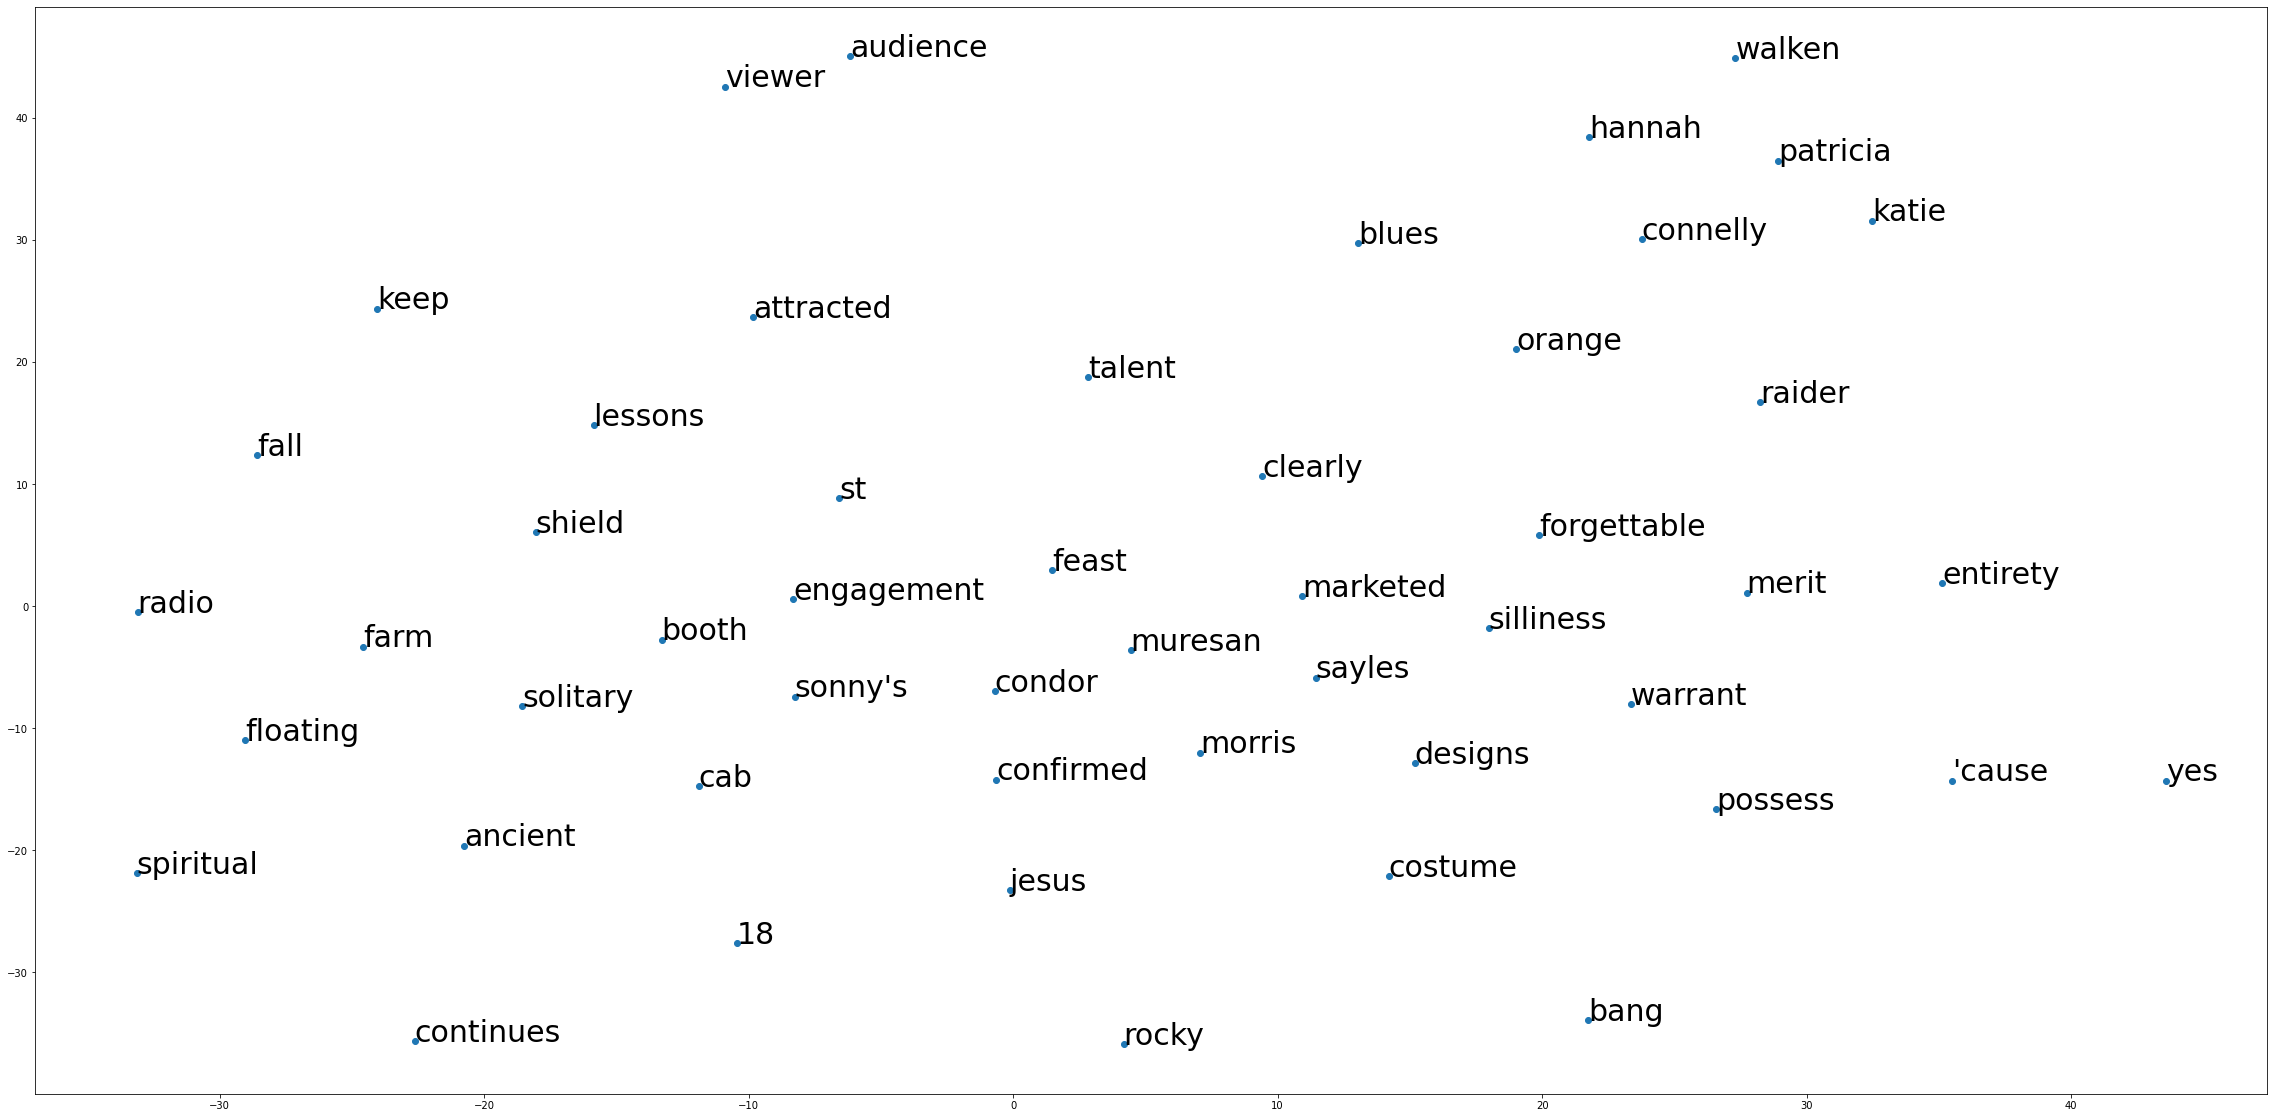

In [ ]:
vocab = list(naive_model.wv.vocab) # Load vocab list
random_vocab = random.sample(vocab,k=50) # Random sampling of 50 words
word_emb = naive_model[random_vocab] # Load embedding vector about sampled words
render_TSNE(random_vocab, word_emb)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


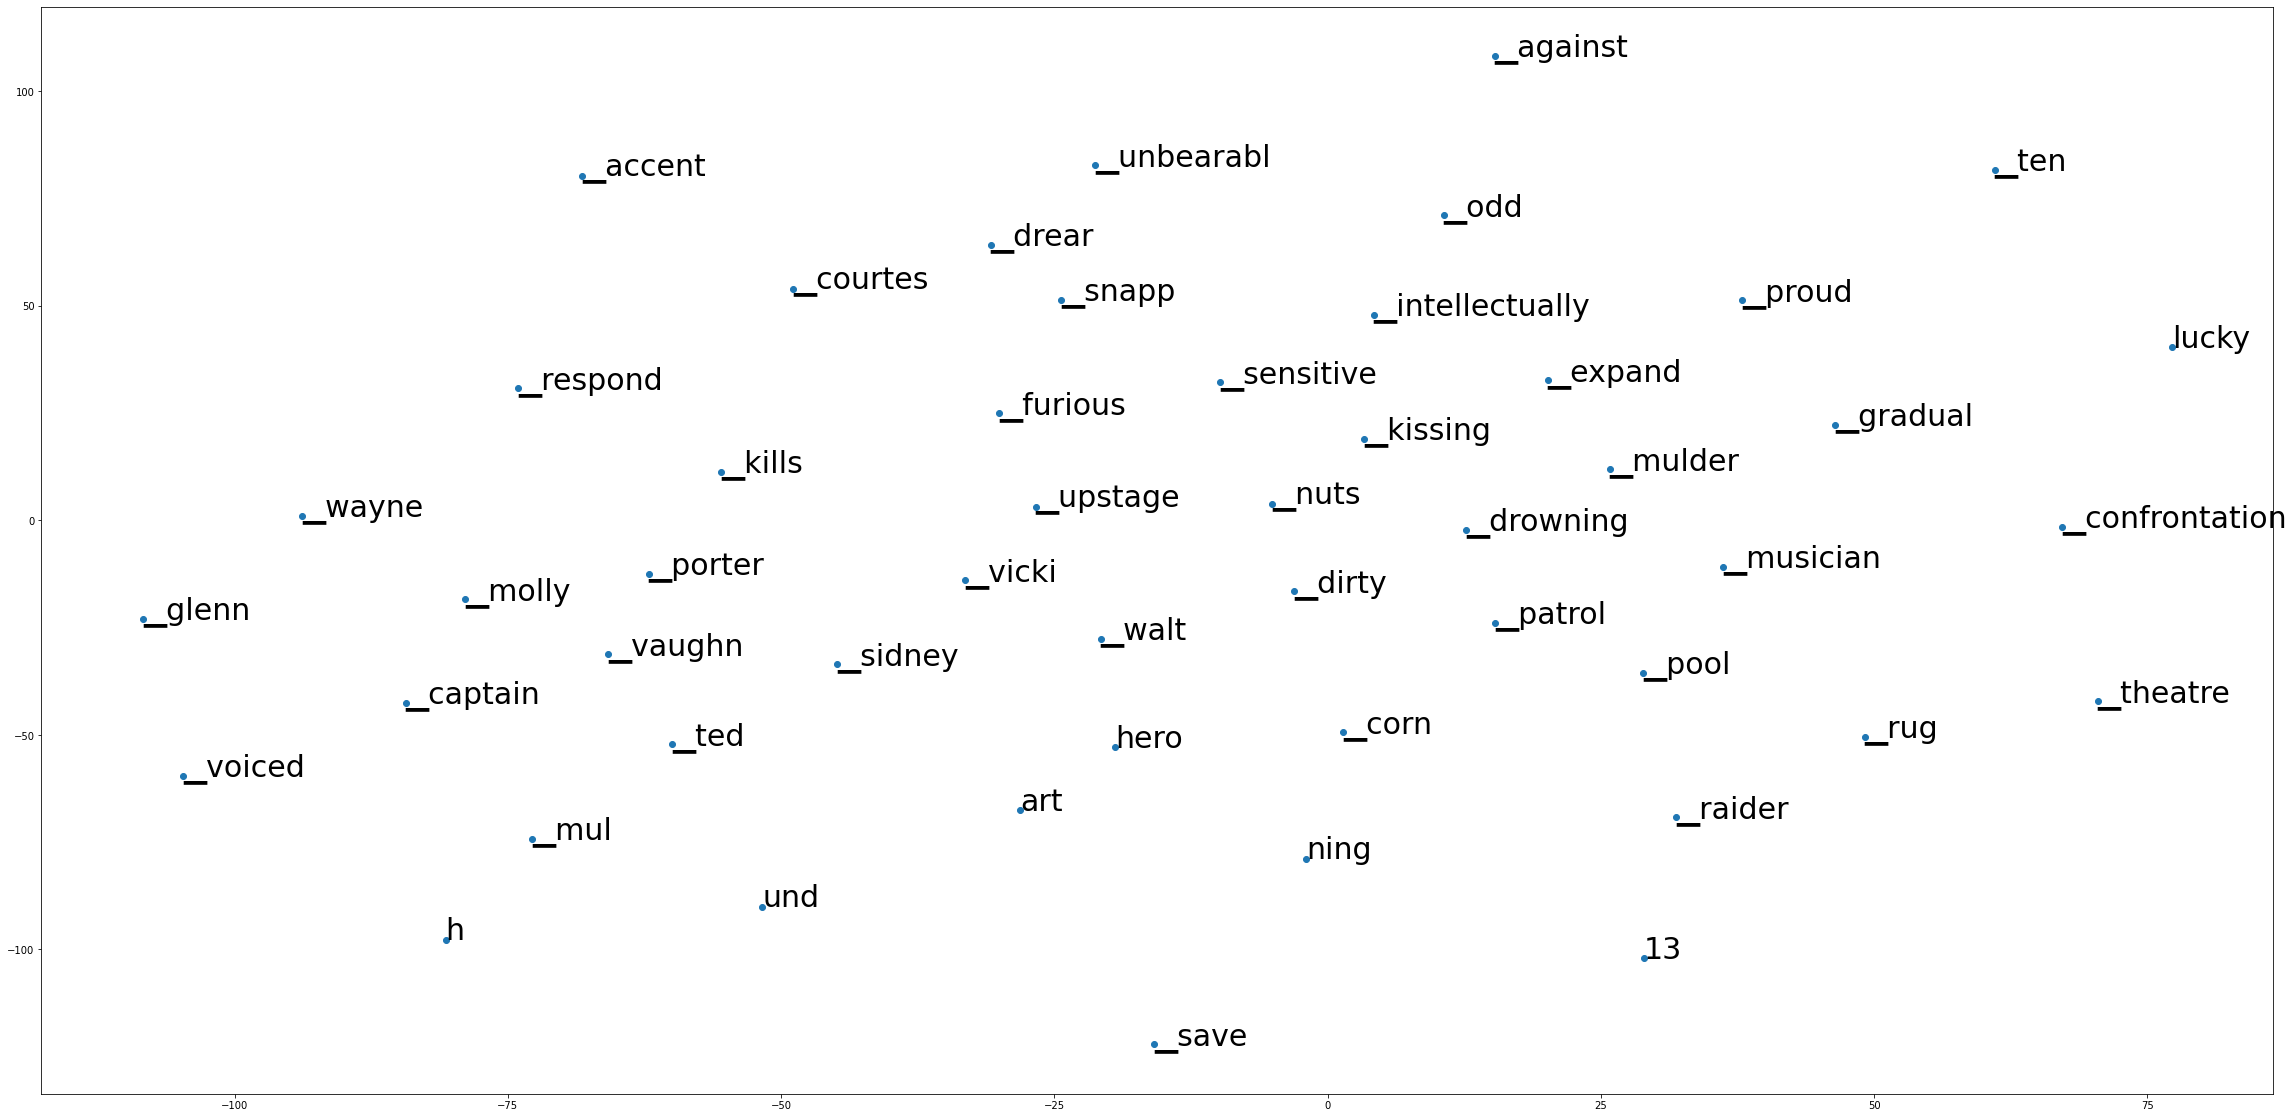

In [ ]:
vocab = list(model_with_SP.wv.vocab) # Load vocab list
random_vocab = random.sample(vocab,k=50) # Random sampling of 50 words
word_emb = model_with_SP[random_vocab] # Load embedding vector about sampled words
render_TSNE(random_vocab, word_emb)

## **HOMEWORK**

I recommend that you know how to use the tool for future lectures or project.

### **Mosestokenizer && BPE**

In [ ]:
############### Reference : http://data.statmt.org/wmt17_systems/training/ ###############
############### Reference : https://github.com/rsennrich/subword-nmt.git #################
############### Reference : http://www.statmt.org/moses/?n=Moses.Baseline #################
# I recommend to see the above reference materials.

git clone https://github.com/moses-smt/mosesdecoder.git
git clone https://github.com/rsennrich/subword-nmt.git

data_dir=/YOUR_DATA_DIRECTORY
model_dir=/SAVED_MODEL_DIRECTORY
type=ALL or TRAIN 
moses_scripts=/mosesdecoder/scripts
bpe_scripts=/subword-nmt
S=de # source language
T=en # target language
bpe_operations=90000

### 1. Tokenizing ###
perl $moses_scripts/tokenizer/tokenizer.perl -threads 5 -l $S < $data_dir/$type.$S > $data_dir/$type.tok.$S
perl $moses_scripts/tokenizer/tokenizer.perl -threads 5 -l $T < $data_dir/$type.$T > $data_dir/$type.tok.$T


### 2. Truecaser ###
## Train -- All corpus or specific domain ##
perl $moses_scripts/recaser/train-truecaser.perl -corpus $data_dir/$data_dir.tok.$S -model $model_dir/truecase-model.$S
perl $moses_scripts/recaser/train-truecaser.perl -corpus $data_dir/$data_dir.tok.$T -model $model_dir/truecase-model.$T

## Apply ##
perl $moses_scripts/recaser/truecase.perl -model $model_dir/truecase-model.$S < $data_dir/$type.tok.$S > $data_dir/$type.tc.$S
perl $moses_scripts/recaser/truecase.perl -model $model_dir/truecase-model.$T < $data_dir/$type.tok.$T > $data_dir/$type.tc.$T

### 3. apply bpe --- 'subword-nmt' command ###
## Train ##
python3 $bpe_scripts/learn_joint_bpe_and_vocab.py -i $data_dir/$type.tc.$S $data_dir/$type.tc.$T --write-vocabulary $data_dir/vocab.$S $data_dir/vocab.$T -s $bpe_operations -o $model_dir/deen.bpe

## Apply ##
python3 $bpe_scripts/apply_bpe.py -c $model_dir/deen.bpe < $data_dir/$type.tc.$S > $data_dir/$type.bpe.$S
python3 $bpe_scripts/apply_bpe.py -c $model_dir/deen.bpe < $data_dir/$type.tc.$T > $data_dir/$type.bpe.$T
